<a href="https://colab.research.google.com/github/funkypro/Telecom-Churn-Predictor/blob/main/Telecom_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It costs 5x more to acquire a new customer than to keep an existing one. A Telecom company wants to know which customers are likely to leave next month so they can offer them a discount today.

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

df = pd.read_csv(url)
# df.to_csv('teleco-customer-churn-dataset.csv')
# print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [2]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [3]:
# convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [4]:
# This automatically converts all 'Object' columns into 0s and 1s
df_encoded = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)

print(df_encoded.head())

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0              0       1           29.85         29.85        False   
1              0      34           56.95       1889.50         True   
2              0       2           53.85        108.15         True   
3              0      45           42.30       1840.75         True   
4              0       2           70.70        151.65        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  MultipleLines_Yes  ...  StreamingTV_Yes  \
0                            True              False  ...            False   
1                           False              False  ...            False   
2                         

In [5]:
# Separating Training and Test Dataset

from sklearn.model_selection import train_test_split

# Define Features (X) and Target (y)
X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Training
model.fit(X_train, y_train)

# Testing
predictions = model.predict(X_test)
print(f"Churn Model Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%")

Churn Model Accuracy: 80.62%


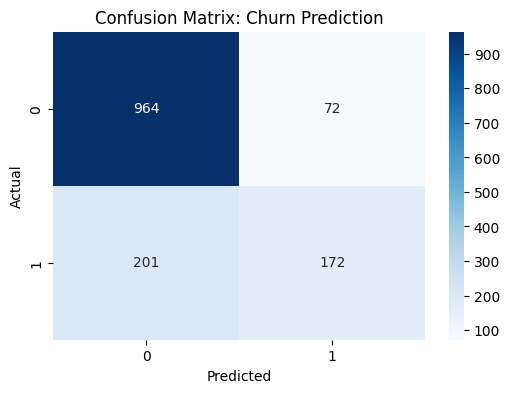

              precision    recall  f1-score   support

       False       0.83      0.93      0.88      1036
        True       0.70      0.46      0.56       373

    accuracy                           0.81      1409
   macro avg       0.77      0.70      0.72      1409
weighted avg       0.80      0.81      0.79      1409



In [7]:
# Using Confusion Matrix to see if the model is catching the people who actully leave

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test, predictions)

# Visualize it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Churn Prediction')
plt.show()

print(classification_report(y_test, predictions))

Implementing Random Forest to fix the Recall

In [8]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize the Random Forest
# 'n_estimators' is the number of trees.
# 'class_weight' helps the model pay more attention to the minority (Churners).
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 2. Fit the model
rf_model.fit(X_train, y_train)

# 3. Predict and Score
rf_predictions = rf_model.predict(X_test)

print(f"New Accuracy: {accuracy_score(y_test, rf_predictions) * 100:.2f}%")
print(classification_report(y_test, rf_predictions))

New Accuracy: 79.91%
              precision    recall  f1-score   support

       False       0.83      0.92      0.87      1036
        True       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



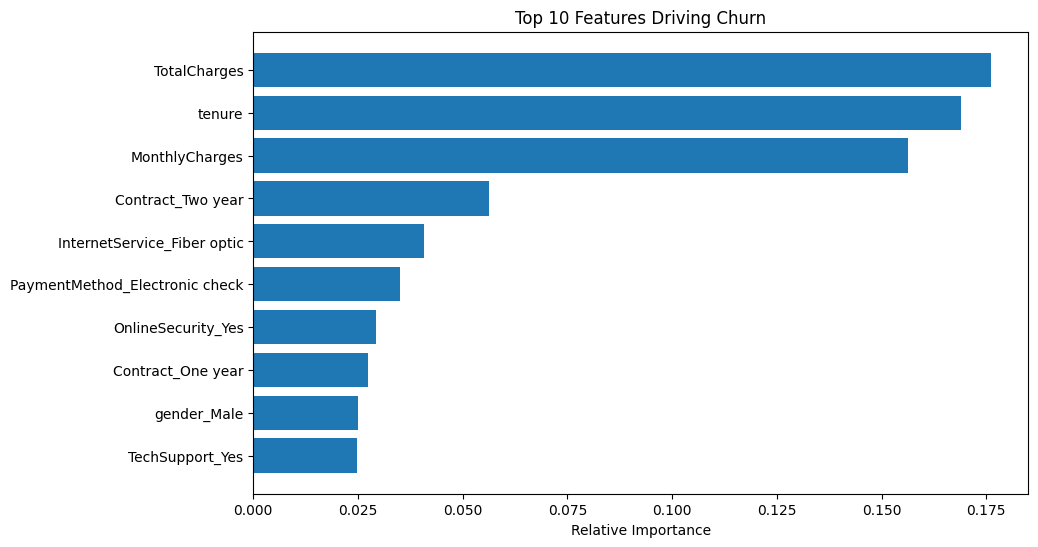

In [9]:
import numpy as np

# Get feature importances from the Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

plt.figure(figsize=(10,6))
plt.title('Top 10 Features Driving Churn')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()